In [49]:
# Imports
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import math
#from VSM_IBVS import VSM_IBVS as V_IBVS
from math import pi
np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})


from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

### Load dataset

In [50]:
# Load dataset inputs and outputs
inputs = np.load('../dataset_generation/dataset/inputs.npy')
outputs = np.load('../dataset_generation/dataset/outputs.npy')

In [51]:
print('nputs shape:', inputs.shape)
print('outputs shape:', outputs.shape)

nputs shape: (2400, 8)
outputs shape: (2400, 6)


In [52]:
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1920, 8)
y_train shape: (1920, 6)
X_test shape: (480, 8)
y_test shape: (480, 6)


### Analyzing dataset

In [53]:
import numpy as np
import pandas as pd

# Assuming X_train and y_train are numpy arrays
data_summary = pd.DataFrame(X_train).describe()
velocity_summary = pd.DataFrame(y_train).describe()

print("Input Data Summary:")
print(data_summary)

print("\nOutput Data (Velocity) Summary:")
print(velocity_summary)

Input Data Summary:
                  0             1             2             3             4  \
count   1920.000000   1920.000000   1920.000000   1920.000000   1920.000000   
mean     608.713154    313.853838    614.357752    228.361044    631.490002   
std     5010.052774   2832.773941   5005.514484   2761.608188   5908.041415   
min    -2509.804580  -7020.129810  -3599.563167  -4438.291707  -3132.561196   
25%      -86.725130    -78.028993    -85.624595   -162.025529   -162.708916   
50%       28.726383     39.068209     30.115975      9.673713    -29.048484   
75%      163.494682    202.114840    174.554605     95.194795     68.754588   
max    78137.415405  43521.302637  78014.299478  42931.640435  92056.266455   

                  5             6             7  
count   1920.000000   1920.000000   1920.000000  
mean     297.558093    628.034210    388.286075  
std     3283.116986   5911.940879   3346.372710  
min    -3715.151101  -2254.512539  -5357.136160  
25%     -157.44495

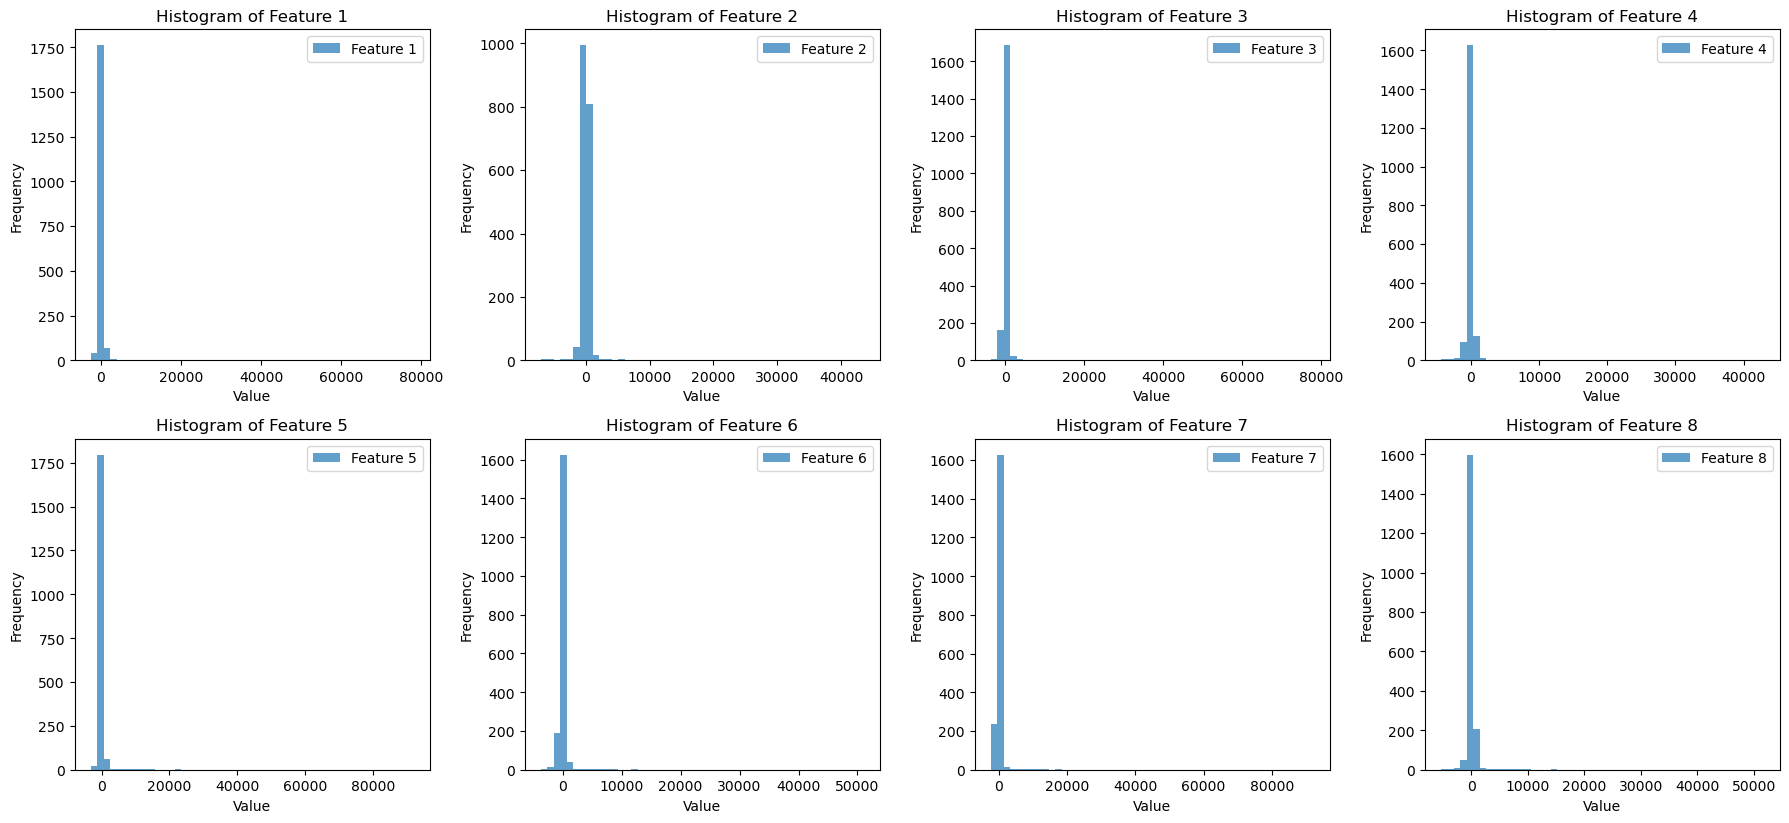

In [54]:
import matplotlib.pyplot as plt

# Flattening the data for visualization
X_train_flat = X_train.flatten()
y_train_flat = y_train.flatten()

# Histogram of each feature of the input data
plt.figure(figsize=(18, 12))
for i in range(X_train.shape[1]):
    plt.subplot(3, 4, i+1)
    plt.hist(X_train[:, i], bins=50, alpha=0.7, label=f'Feature {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Feature {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

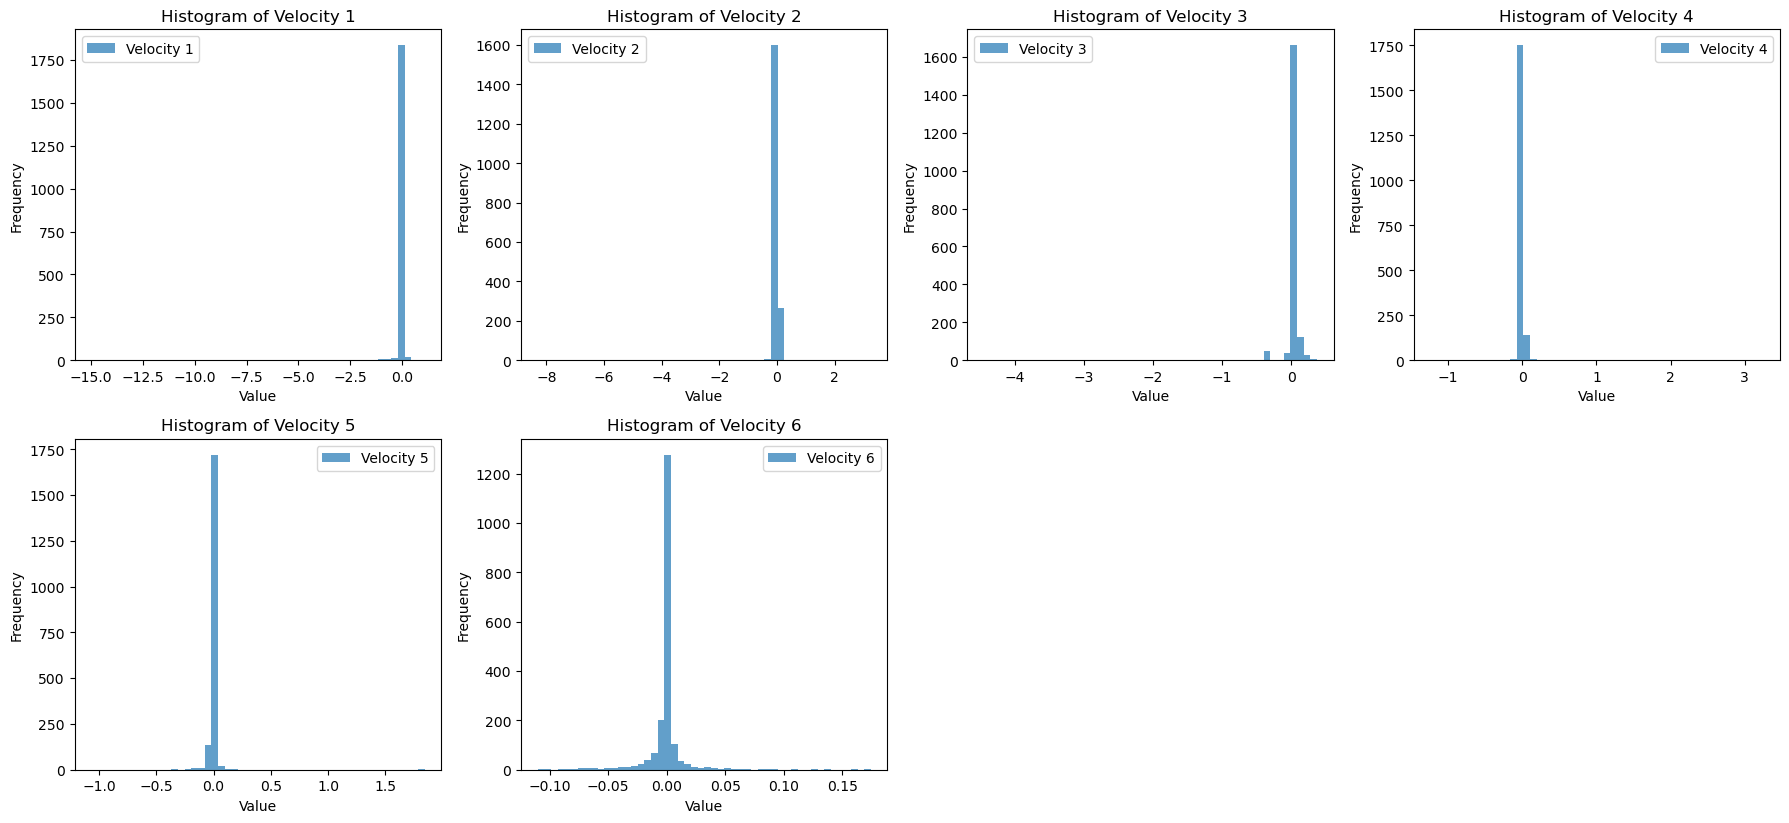

In [55]:
# Histogram of the output data
plt.figure(figsize=(18,12))
for i in range(y_train.shape[1]):
    plt.subplot(3, 4, i+1)
    plt.hist(y_train[:, i], bins=50, alpha=0.7, label=f'Velocity {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Velocity {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

In [56]:
# print min and max values of the input and output data
print("Min value of input data:", X_train.min())
print("Max value of input data:", X_train.max())
print("Min value of output data:", y_train.min())
print("Max value of output data:", y_train.max())

Min value of input data: -7020.129810210614
Max value of input data: 92215.727663151
Min value of output data: -14.990341928829253
Max value of output data: 3.2583862634574645


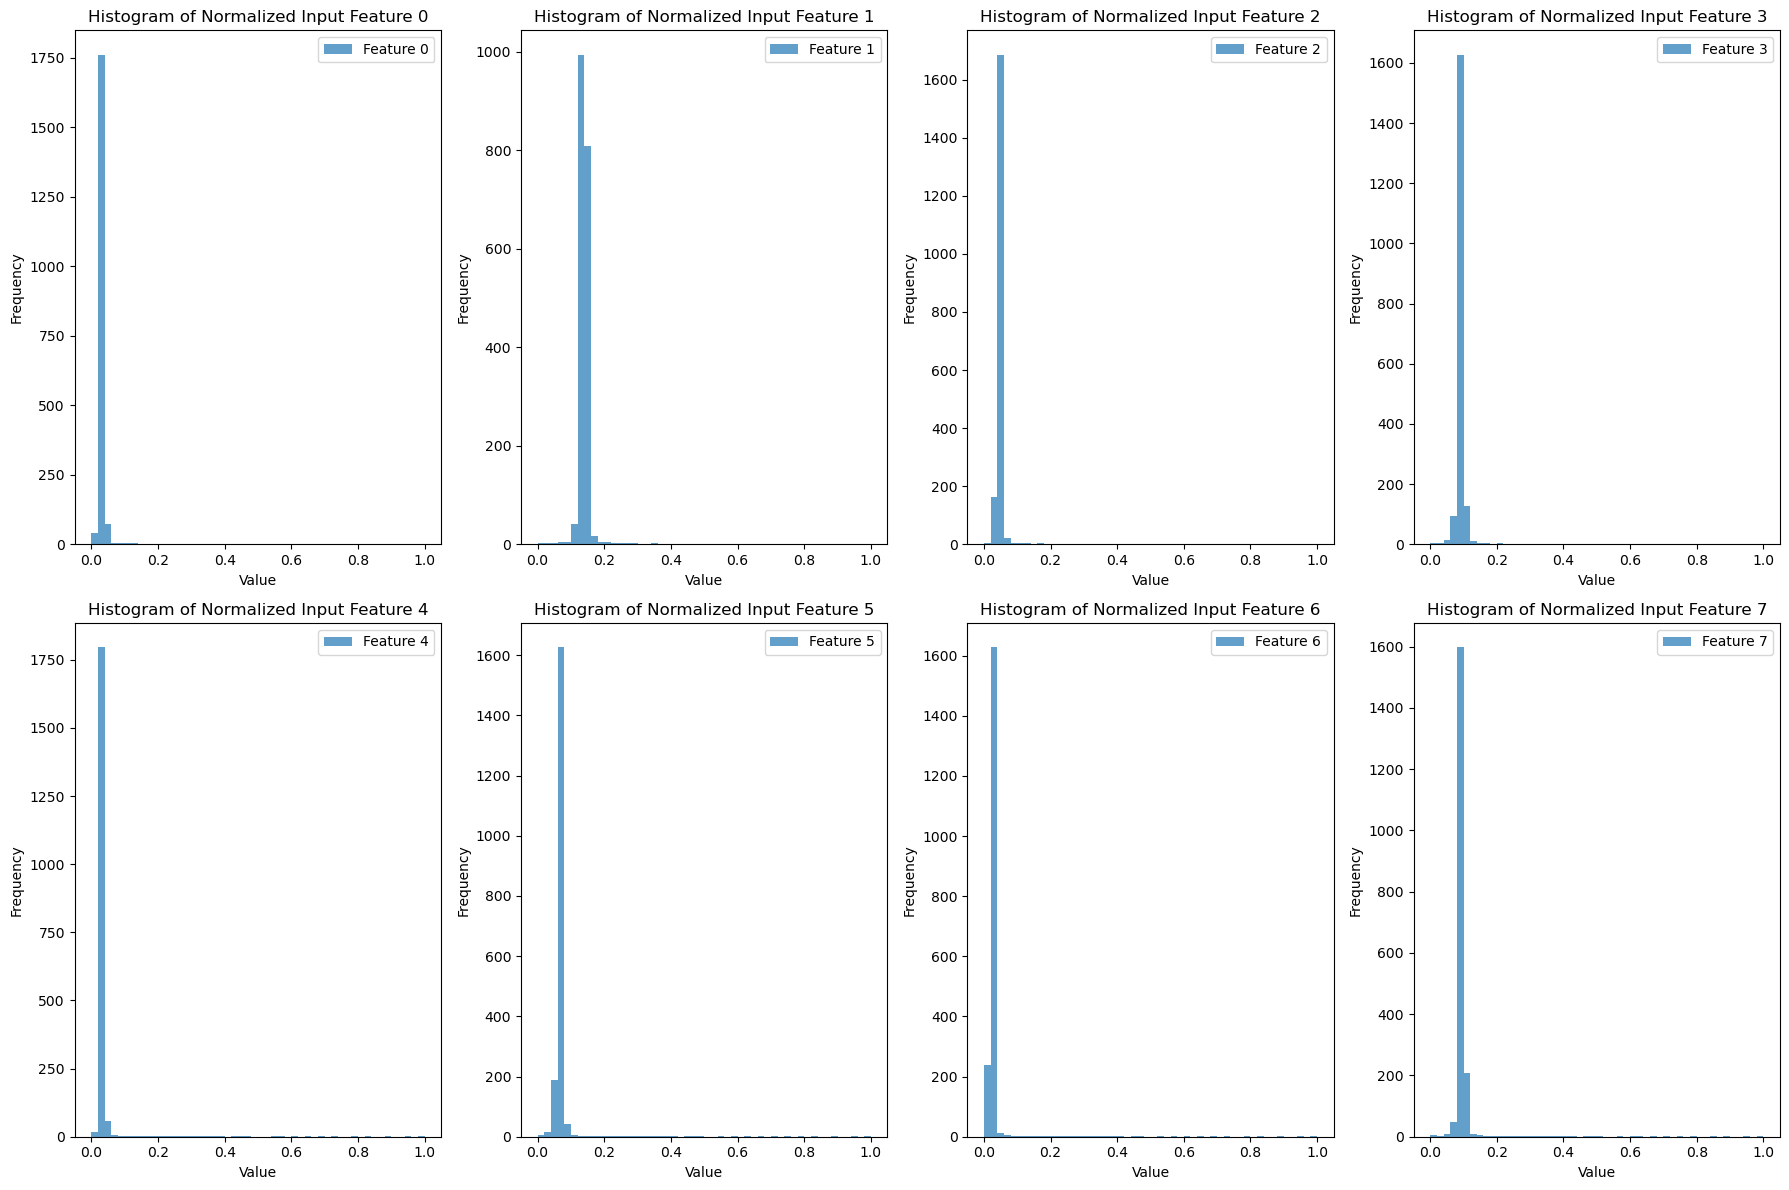

In [57]:
# Normalizing the input data
from sklearn.preprocessing import MinMaxScaler

# Normalize the input data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Histogram for each of the input components
plt.figure(figsize=(18, 12))
for i in range(data_summary.shape[1]):
    plt.subplot(2, 4, i+1)  # Create subplot in a 2x4 grid
    plt.hist(X_train[:, i], bins=50, alpha=0.7, label='Feature ' + str(i))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Normalized Input Feature ' + str(i))
    plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


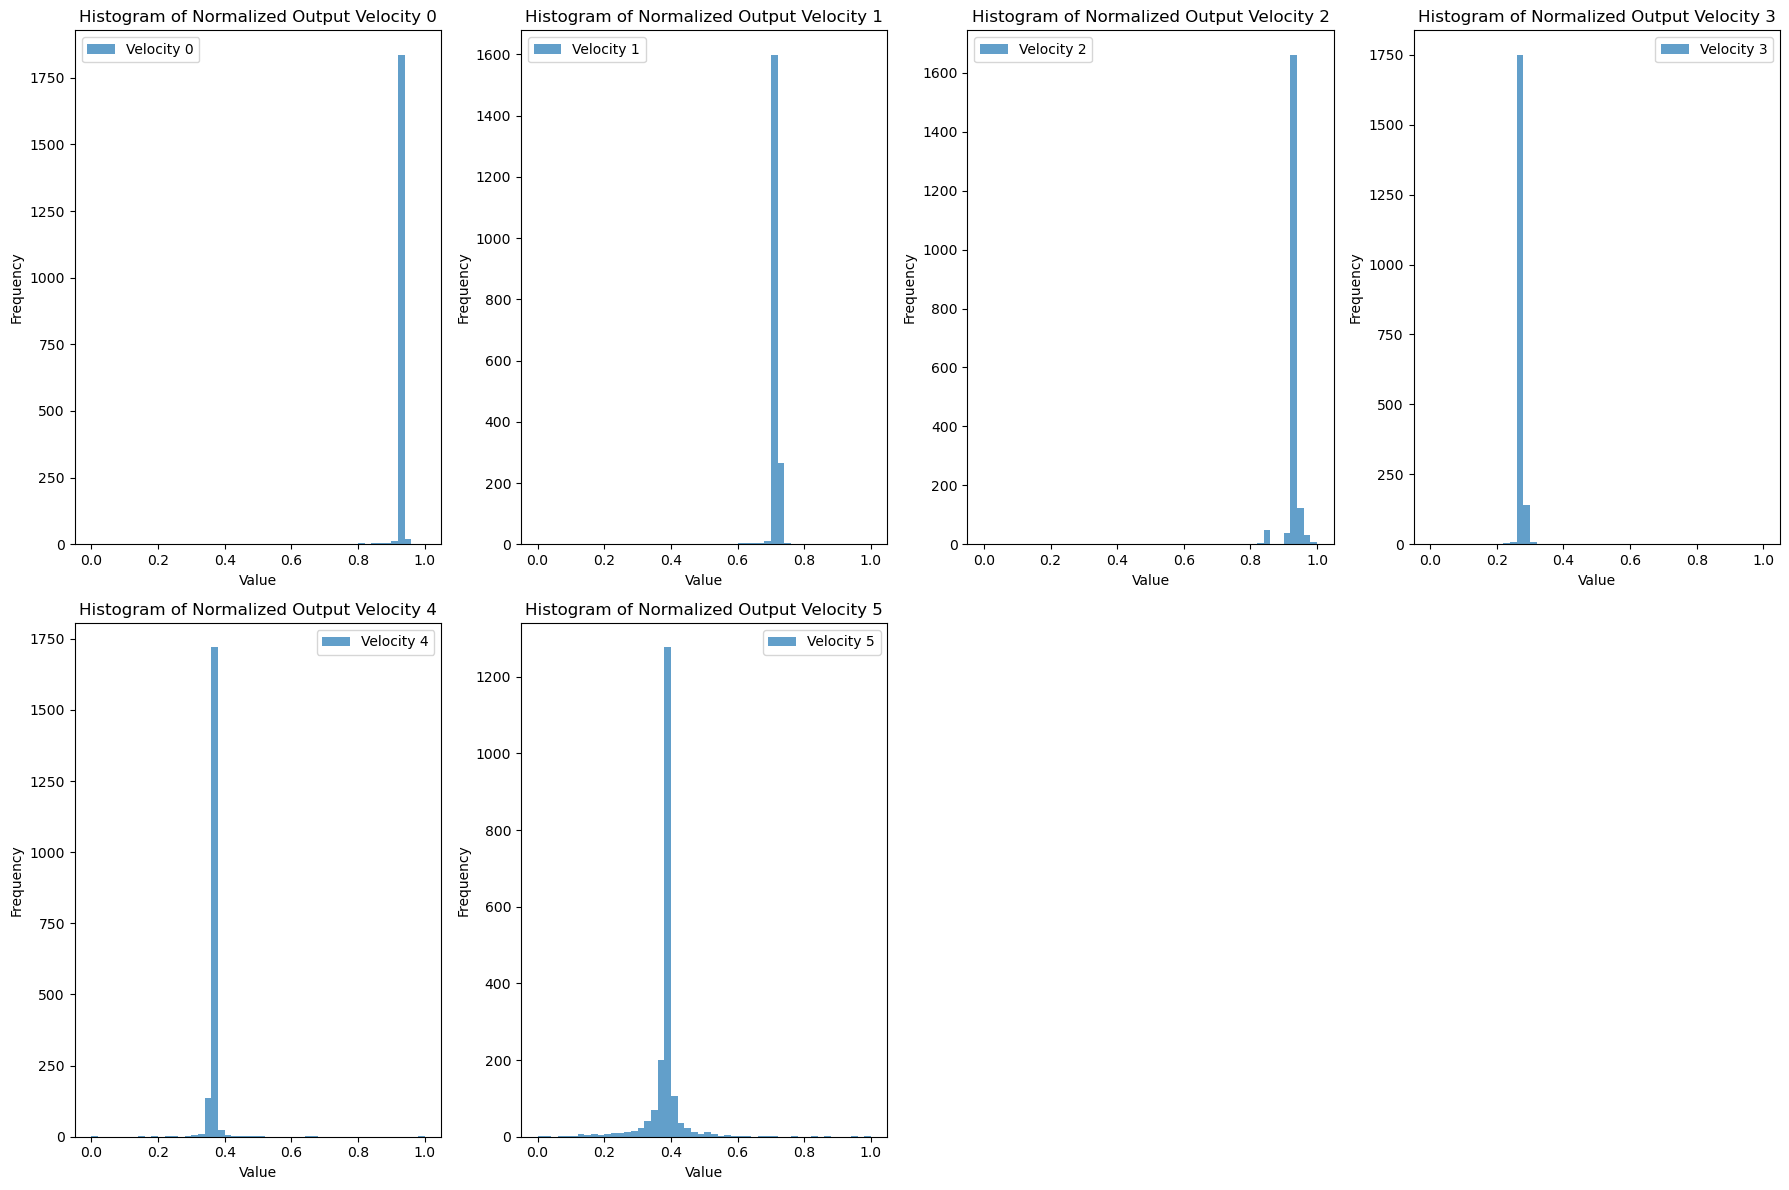

In [58]:
# Normalize output velocities
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Histogram for each of the output components
plt.figure(figsize=(18, 12))
for i in range(velocity_summary.shape[1]):
    plt.subplot(2, 4, i+1)  # Create subplot in a 2x4 grid
    plt.hist(y_train[:, i], bins=50, alpha=0.7, label='Velocity ' + str(i))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Normalized Output Velocity ' + str(i))
    plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### Model building

In [59]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

# Build the model
model = Sequential()
model.add(Input(shape=(8,)))  # Input layer

model.add(Dense(128, activation='relu'))  # Hidden layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(64, activation='relu'))  # Hidden layer

model.add(Dense(6))  # Output layer

### Train model

In [60]:
# Training the model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy, RootMeanSquaredError

# Define the RMSE loss function
def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model.compile(optimizer='rmsprop',
                loss=MeanSquaredError(), 
                metrics=[RootMeanSquaredError()])
                
history = model.fit(X_train, 
          y_train,
          epochs=50, 
          batch_size=64, 
          validation_split=0.2)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3063 - root_mean_squared_error: 0.5496 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1414
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0321 - root_mean_squared_error: 0.1758 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - root_mean_squared_error: 0.0866 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0381
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.001

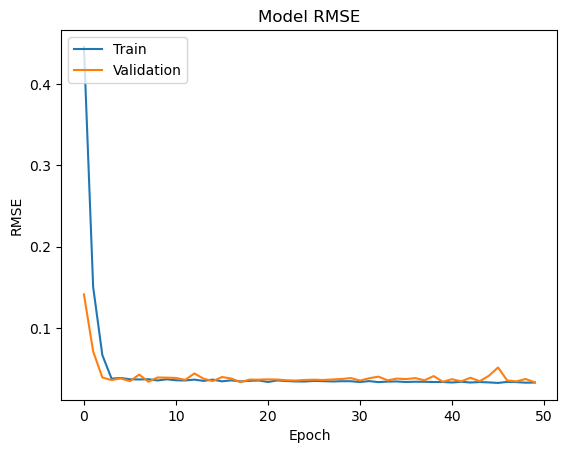

In [61]:
# Plot training and validation root mean squared error
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

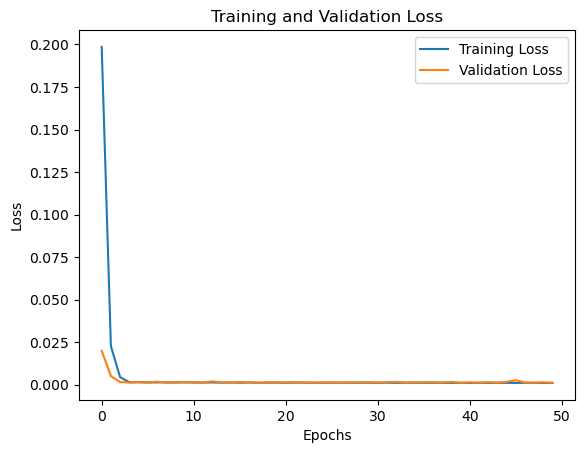

In [62]:
# Plot the training loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Validate the model

In [63]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5963e-04 - root_mean_squared_error: 0.0304
Loss: 0.0006414043018594384


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


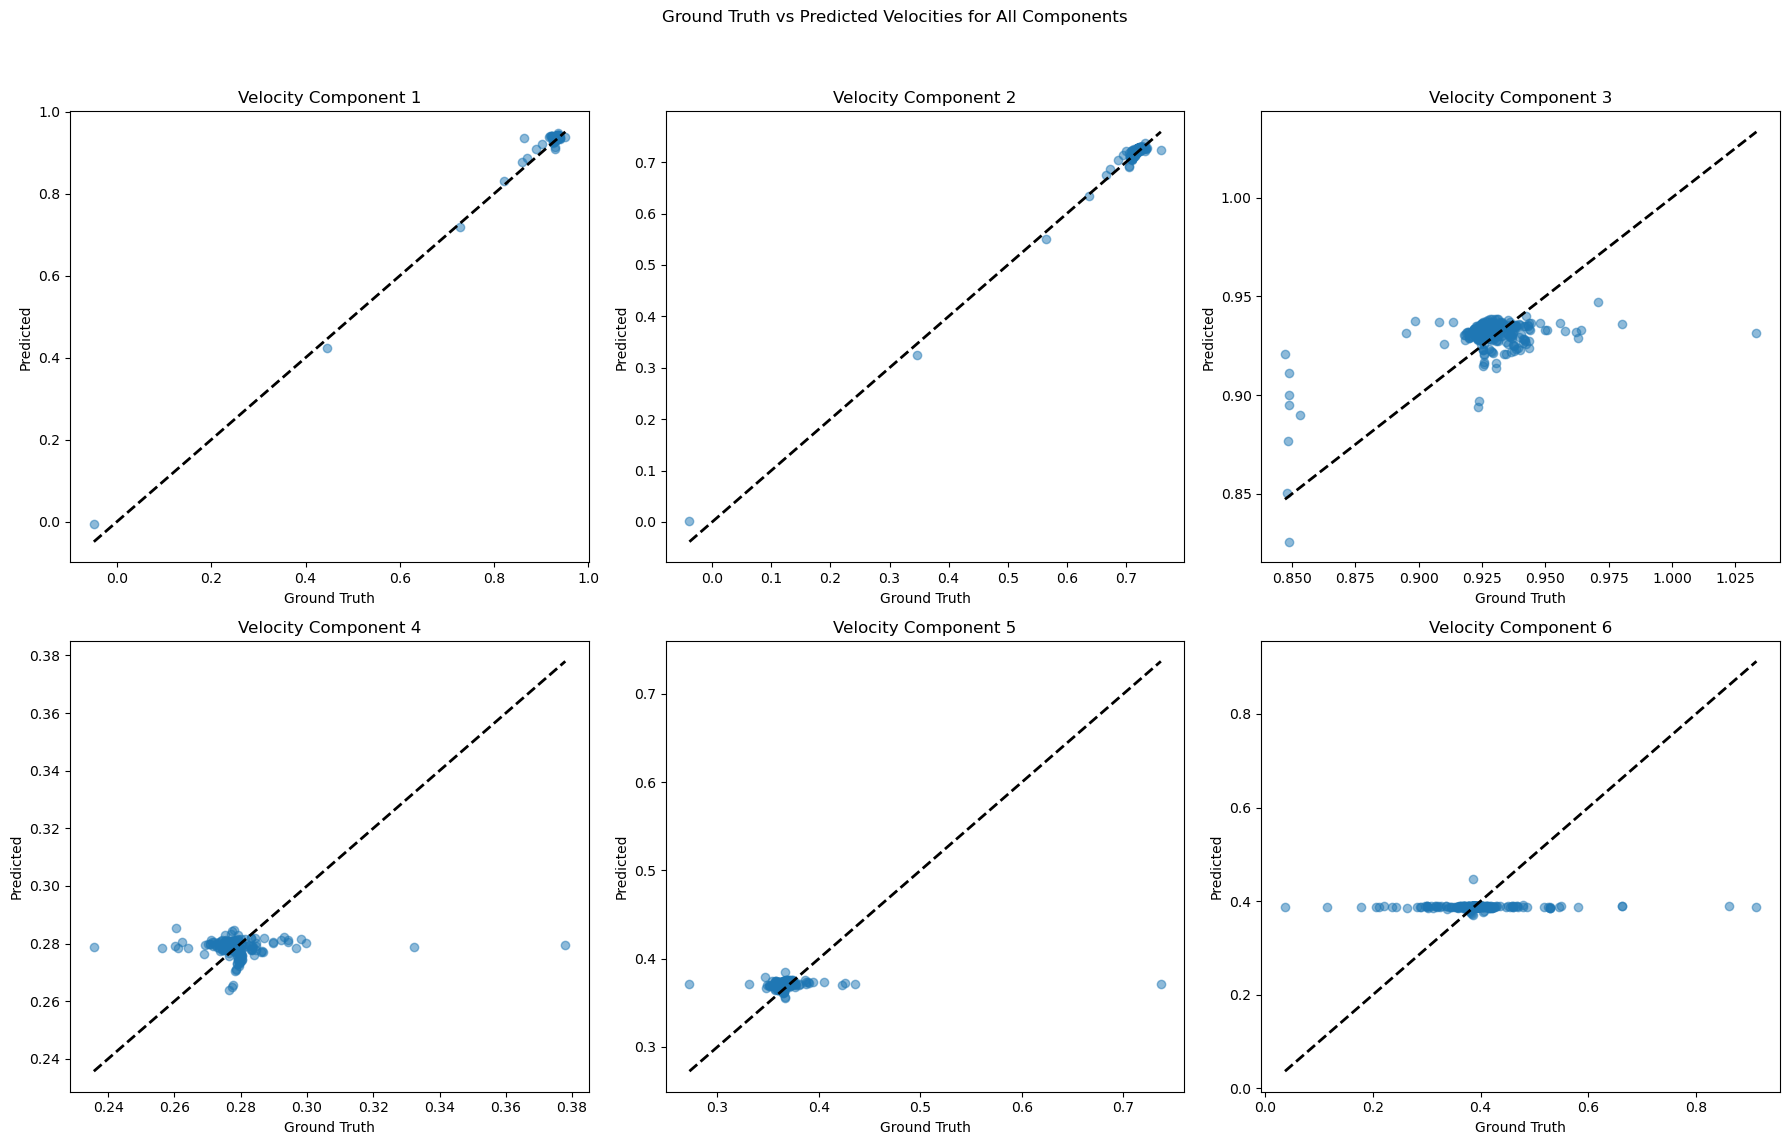

In [64]:
# Make one plot for each of the  velocity components
y_pred = model.predict(X_test)

# Denormalize the output velocities
y_pred_denormalized = scaler.inverse_transform(y_pred)
y_test_denormalized = scaler.inverse_transform(y_test)

# Initialize a figure for a 2x3 grid of subplots
plt.figure(figsize=(18, 12))

for i in range(6):
    # Create subplot in a 2x3 grid
    plt.subplot(2, 3, i+1)
    # Plot the predicted and ground truth velocities
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'k--', lw=2)  # Add a line of y=x for reference
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.title(f'Velocity Component {i+1}')

plt.suptitle('Ground Truth vs Predicted Velocities for All Components')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

### Save model

In [65]:
# Save model
model.save('models/uv_pstar.keras')